In [1]:
import os
import numpy as np
import cv2
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class AgeDataset(Dataset):
    def __init__(self, paths, age_labels, transform=None):
        self.paths = paths
        self.age_labels = age_labels
        self.transform = transform
        self.max_age = 116

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img_path = self.paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        age = float(self.age_labels[index])
        age = age / self.max_age
        return img, age


In [3]:
PATH = 'utkface_aligned_cropped/UTKFace'
paths = [os.path.join(PATH, x) for x in os.listdir(PATH)]
labels = np.array([float(os.path.basename(path).split('_')[0]) for path in paths])

In [4]:
len(paths)

23708

In [5]:
# transform = transforms.Compose([
#     transforms.Resize((128,128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
train_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([transforms.Resize([256, 256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


In [6]:
#train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.2)

In [7]:
# train_dataset = AgeDataset(train_paths, train_labels, transform=transform)
# test_dataset = AgeDataset(test_paths, test_labels, transform=transform)

In [8]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
dataset = AgeDataset(paths, labels, transform=train_transforms)
total_size = len(dataset)
print(total_size)

23708


In [10]:
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
test_dataset.transform = test_transforms

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
class MobileNetRegression(nn.Module):
    def __init__(self):
        super(MobileNetRegression, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet = self.mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(self.mobilenet[-1].out_channels, 1)

    def forward(self, x):
        x = self.mobilenet(x)
        x = self.pool(x)
        x = self.drop(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev="cpu"
    return torch.device(dev)

device = set_device()

In [14]:
model = MobileNetRegression().to(device)

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

In [16]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_loader.dataset)}')
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.3f}')

Epoch [1/15], Training Loss: 0.13078320075963484
Epoch [1/15], Validation Loss: 0.073
Epoch [2/15], Training Loss: 0.06988216817073702
Epoch [2/15], Validation Loss: 0.060
Epoch [3/15], Training Loss: 0.063497364969992
Epoch [3/15], Validation Loss: 0.058
Epoch [4/15], Training Loss: 0.059975213880961324
Epoch [4/15], Validation Loss: 0.057
Epoch [5/15], Training Loss: 0.05737366225210146
Epoch [5/15], Validation Loss: 0.063
Epoch [6/15], Training Loss: 0.05613619184307249
Epoch [6/15], Validation Loss: 0.056
Epoch [7/15], Training Loss: 0.056024591978072545
Epoch [7/15], Validation Loss: 0.054
Epoch [8/15], Training Loss: 0.0531677289481765
Epoch [8/15], Validation Loss: 0.054
Epoch [9/15], Training Loss: 0.051064676949689816
Epoch [9/15], Validation Loss: 0.054
Epoch [10/15], Training Loss: 0.05202753395156424
Epoch [10/15], Validation Loss: 0.051
Epoch [11/15], Training Loss: 0.05090435263118531
Epoch [11/15], Validation Loss: 0.054
Epoch [12/15], Training Loss: 0.05062834309252963


In [17]:
# Test model
model.eval()
total_loss = 0
total_mae = 0 # mean absolute error
with torch.no_grad():
    for images, ages in test_loader:
        images, ages = images.to(device), ages.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), ages.float())
        total_loss += loss.item() * images.size(0)
    
        mae = torch.mean(torch.abs(outputs.squeeze() - ages.float())).item()
        total_mae += mae * images.size(0)
    
avg_loss = total_loss / len(test_loader.dataset)
avg_mae = total_mae / len(test_loader.dataset)
print(f'Test Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}')

Test Loss: 0.0472, MAE: 0.0472


In [33]:
print(outputs *116)

tensor([[27.1071],
        [36.9926],
        [16.0136],
        [43.8157],
        [23.5681],
        [22.2203],
        [33.3362],
        [26.9218],
        [24.8988],
        [40.2682],
        [71.0994],
        [67.5912],
        [34.9872],
        [52.6799],
        [48.3311],
        [29.1697],
        [ 1.2011],
        [44.6322],
        [ 0.9637],
        [53.4461],
        [14.1771],
        [43.4157],
        [25.8479],
        [ 0.8634],
        [71.4772],
        [32.0923],
        [62.2719],
        [25.8681],
        [37.1680],
        [ 0.8607],
        [52.5606],
        [36.4686],
        [60.3670],
        [34.5840],
        [33.8507],
        [ 0.1473],
        [33.0385]])


In [34]:
print(ages * 116)

tensor([31.0000, 30.0000, 17.0000, 40.0000, 12.0000, 20.0000, 32.0000, 23.0000,
        15.0000, 70.0000, 79.0000, 65.0000, 28.0000, 39.0000, 58.0000, 28.0000,
         2.0000, 56.0000,  2.0000, 52.0000, 16.0000, 38.0000, 23.0000,  2.0000,
        80.0000, 26.0000, 72.0000, 33.0000, 41.0000,  3.0000, 50.0000, 50.0000,
        55.0000, 35.0000, 26.0000,  1.0000, 36.0000], dtype=torch.float64)


In [18]:
torch.save(model.state_dict(), 'age_estimation_model3.pth')

In [19]:
new_model = MobileNetRegression().to(device)
new_model.load_state_dict(torch.load('age_estimation_model3.pth'))

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [20]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    return test_transforms(img).unsqueeze(0)

Predicted value: 20.385335683822632


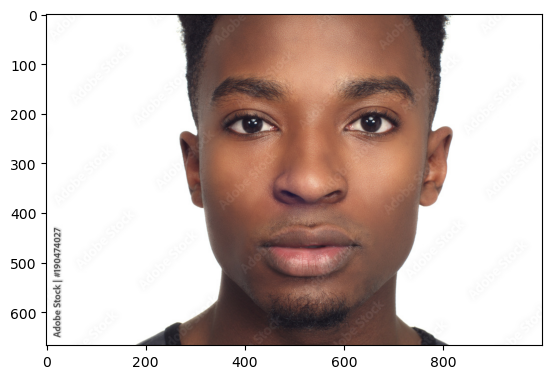

In [30]:
img_path = 'images/man.jpg'
img_tensor = preprocess_image(img_path)
new_model.eval()
with torch.no_grad():
    prediction = model(img_tensor.to(device))
    print(f"Predicted value: {prediction.item() * 116}")

# Display the image
img = Image.open(img_path)
plt.imshow(img)
plt.show()